# Mute linear events and stack

For this I'll combine two types of mutting, first a custom mute to remove linear events, and then a hyperbolic mute a little above the sea floor reflection.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import m8r as sf

%matplotlib inline

# Set a custom DATAPATH to Madagascar
%env DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/

env: DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/


In [19]:
sns.set_style('ticks')

## Use a simple tappered mute on t-x domain (common shot domain)

In [3]:
from scipy.interpolate import interp1d

In [25]:
# Read manual picks (to remove linear events w/o killing shallow reflections)

# Since the sea floor has a constant depth, just one mute function ought to be enough.

picks = pd.read_csv('mute_picks.csv')

# Now, I just need to interpolate and repeat for all shots

x = np.arange(120)

picks = interp1d(picks.CHANNEL, picks.TWT)
picks = picks(x)

Now lets plot the mute on a custom shot.

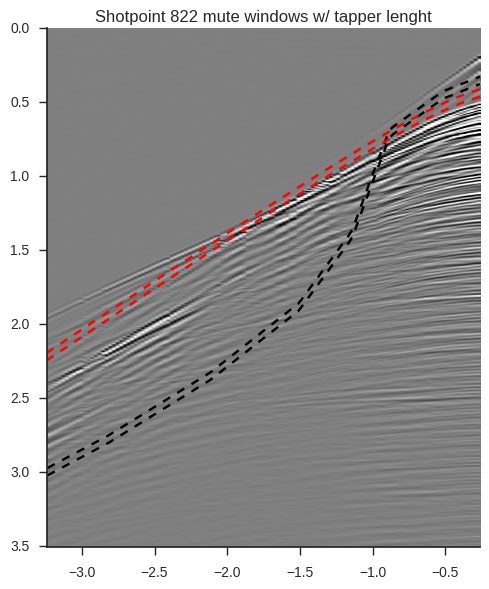

In [66]:
rec_deghost = 'receiver_deghost.rsf'
tp=0.05 # mute tapper duration (s)
t0=.187 # hyperbolic mute start time
v0=1.5 # hyperbolic mute duration

img = sf.Input(rec_deghost)
d1 = img.float('d1')

# Grab well 5 shotpoint
img = np.array(sf.window(n3=1, max1=3.5, f3=713).byte(pclip=99, gainpanel='each')[img]).T
x = np.arange(img.shape[1])*-0.025 - 0.262
extent = [x[-1], x[0], d1*img.shape[0], 0]

plt.figure(figsize=(5,6))
plt.imshow(img, aspect='auto', extent=extent, cmap='gray_r')

# Plot the custom mute
plt.plot(x[::-1], picks, 'k', ls='--')
plt.plot(x[::-1], picks+tp, 'k', ls='--')

# water bottom reflection hyperbolic mute
y = 2* np.sqrt(x**2/(4*v0**2) + t0**2)
plt.plot(x, y, 'r', ls='--')
plt.plot(x, y + tp, 'r', ls='--')

plt.title('Shotpoint 822 mute windows w/ tapper lenght')

plt.axis('tight')
sns.despine()
plt.tight_layout()

In [5]:
out = sf.Output('mute_picks.rsf')
out.put('n1', picks.size)
out.write(picks.astype(np.float))
out.close()

In [6]:
picks = 'mute_picks.rsf'
custom_mute = 'custom_mute.rsf'

!sfspray n=1001 < {picks} > {custom_mute}

In [7]:
mutted_shots = 'mutted_shots.rsf'

# Hackysh tip: Using v0=2 makes it possible to mute custom times
# by inputting the desired times as offsets at sfmutter

!sfpow tpow=2 < {rec_deghost} | sfput o2=-3.237 d2=0.025 |\
    sfmutter v0=2 offset={custom_mute} tp=0.05 |\
    sfmutter hyper=y half=n t0=.187 tp=0.05 v0=1.5 > {mutted_shots}

In [8]:
mutted_cdps = 'line_cdp_mutted.rsf'
header_int = 'line_12_header_int.rsf'

!sfintbin < {mutted_shots} head={header_int} yk=cdp xk=cdpt > {mutted_cdps}

sfintbin: 2142 of 2142;


In [9]:
mask = 'line_cdp_mask.rsf'
offsets = 'line_cdp_offset.rsf'
mutted_stack = 'mutted_brute_stack.rsf'
vstk = 'first_stacking_velocity.rsf'
mutted_nmo_cdps = 'mutted_cdps.rsf'


!sfpow tpow=2 < {mutted_cdps} | \
    sfnmo velocity={vstk} offset={offsets} mask={mask} half=n > {mutted_nmo_cdps}

sfnmo: CMP 2142 of 2142;MP 585 of 2142;CMP 818 of 2142;CMP 846 of 2142;CMP 1520 of 2142;CMP 1676 of 2142;CMP 2085 of 2142;


In [10]:
!sfstack < {mutted_nmo_cdps} > {mutted_stack}

In [11]:
from matplotlib_scalebar.scalebar import ScaleBar

In [15]:
img = sf.Input(mutted_stack)

n1 = img.int('n1')
n2 = img.int('n2')
d1 = img.float('d1')
o1 = img.float('o1')
d2 = img.float('d2')
o2 = img.float('o2')

data = np.zeros((n2, n1), dtype=np.float32)
img.read(data)

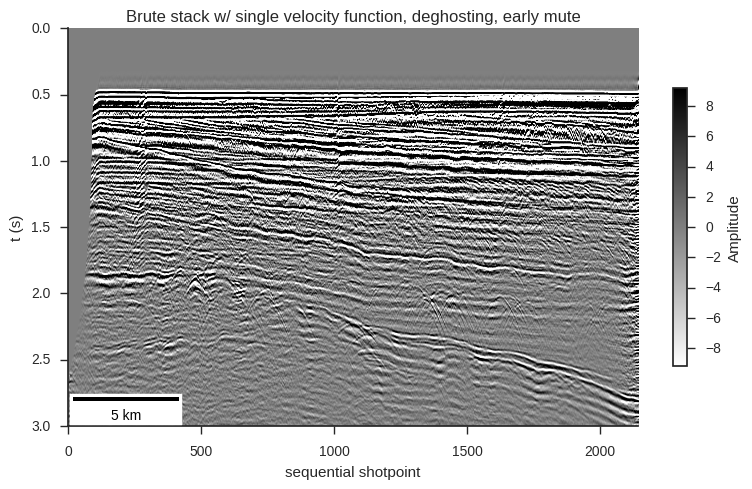

In [16]:
perc = np.percentile(data.ravel(), 95)
t = np.arange(n1) * d1 + o1
extent = [0, n2, t[-1], o1]
plt.figure(figsize=(8, 5))
img = plt.imshow(data.clip(-perc, perc).T, aspect='auto',
                 extent=extent, cmap='gray_r')


scalebar = ScaleBar(12.5, location='lower left') # 1 pixel = 25 meter
plt.gca().add_artist(scalebar)

plt.ylabel('t (s)')
plt.xlabel('sequential shotpoint')

plt.ylim(3,0)

plt.title('Brute stack w/ single velocity function, deghosting, early mute')

sns.despine()
plt.colorbar(img, shrink=0.7, label='Amplitude')

plt.tight_layout()